(gradients)=

# Градиенты квантовых схем

Автор(ы):

- [Синченко Семен](https://github.com/SemyonSinchenko)


## Описание лекции

В этой лекции мы детально разберем, как можно оптимизировать параметры VQC:

- Как выглядит цикл обучения квантовой схемы
- Как работает оценка градиента "под капотом"
  - Метод конечных отрезков
  - Parameter-shift rule

## Введение

Как мы уже говорили ранее, VQC выступают в роли "черных ящиков", которые имеют параметры и как-то преобразуют поступающие в них данные. В этом случае сам процесс оптимизации параметров выполняется на классическом компьютере. Одними из самых эффективных на сегодня методов решения задач непрерывной оптимизации являются градиентные методы. Для этих методов разработан широкий арсенал эвристик и приемов, который применяется в обучении классических глубоких нейронных сетей. Очень хочется применить весь этот арсенал и для квантового машинного обучения. Но как же посчитать градиент вариационной квантовой схемы?

## Задача лекции

На этой лекции мы рассмотрим простую задачку по оптимизации параметров квантовой схемы и на ее примере увидим, как работают квантовые градиенты. В качестве задачи возьмем известный набор данных "Two Moon" из библиотеки `scikit-learn`:

In [1]:
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=50)

Для удобства мы сразу переведем метки классов из $\{0, 1\} \to \{-1, 1\}$, а признаки $\mathbf{X}$ переведем в $[0, \pi]$:

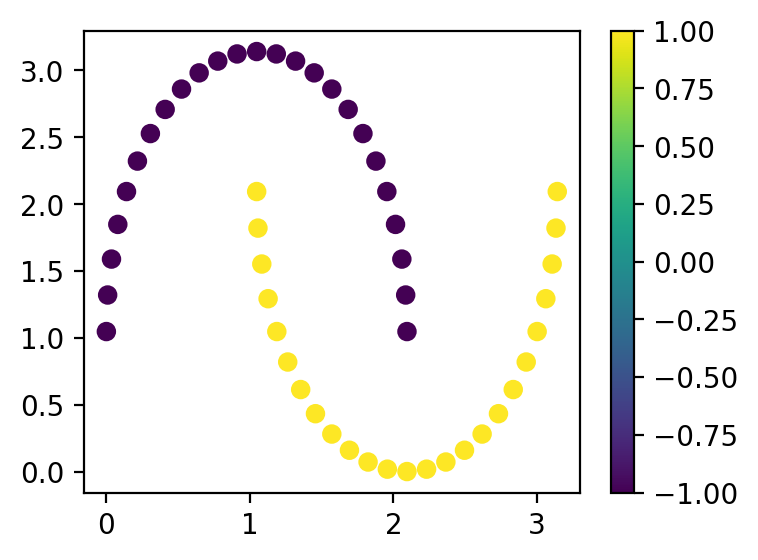

In [2]:
def normalize(x):
    """
    Переводит значения в интервал от 0 до pi
    """
    min_ = x.min()
    max_ = x.max()
    return np.pi * (x - min_) / (max_ - min_)

x[:, 0] = normalize(x[:, 0])
x[:, 1] = normalize(x[:, 1])
y = y * 2 - 1

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar(cb)
plt.show()

## Вариационная схема

Перед тем как мы начнем обучение и будем считать градиенты, нам необходимо определиться с тем, как будет выглядеть наша вариационная схема. Мы посвятим кодированию данных, выбору архитектуры схемы, а также измеряемого оператора еще много занятий. Так что пока просто воспользуемся кодированием признаков $\mathbf{X}$ вращениями, а сверху применим несколько параметризованных слоев вращений.

### Кодирование признаков

In [3]:
dev = qml.device("default.qubit", 2)

def encoding(x1, x2):
    qml.RY(x1, wires=0)
    qml.RY(x2, wires=1)
    qml.RZ(x1, wires=0)
    qml.RZ(x2, wires=1)
    qml.CZ(wires=[0, 1])

### Параметризованные слои

В качестве одного слоя обучения мы будем использовать параметризованные вращения в связке с двухкубитным гейтом для создания запутанных состояний.

```{note}
Более детально о запутанных состояниях, а также квантовой энтропии и черных дырах можно посмотреть в [продвинутой лекции](../../qc/ru/mixedstates.md) блока про квантовые вычисления.
```

В этой лекции у нас нет цели идеально решить поставленную задачу -- на самом деле это чуть сложнее, чем может показаться на первый взгляд. Поэтому пока не будем излишне усложнять нашу **VQC**. Сделаем нашу **VQC** содержащей несколько "слоев" следующего вида:

- Вращение 1-го кубита $\hat{Rot}(\theta_1^1, \theta_1^2, \theta_1^3)$
- Вращение 2-го кубита $\hat{Rot}(\theta_2^1, \theta_2^2, \theta_2^3)$
- "Запутывающий" оператор, который действует на оба кубита сразу -- в нашем случае это $\hat{CZ}$

Как видно, на каждый "слой" у нас приходится шесть параметров. Реализуем это в коде:

In [4]:
def layer(theta):
    qml.Rot(theta[0, 0], theta[0, 1], theta[0, 2], wires=0)
    qml.Rot(theta[1, 0], theta[1, 1], theta[1, 2], wires=1)
    qml.CZ(wires=[0, 1])

Здесь у нас вращения каждого из кубитов по сфере Блоха и двухкубитное взаимодействие $\hat{CZ}$.

### Все вместе

Теперь давайте объединим все это вместе, добавим пару наблюдаемых и оформим как `qml.qnode`:

In [5]:
@qml.qnode(dev)
def node(x1, x2, q):
    encoding(x1, x2)
    for q_ in q:
        layer(q_)

    return qml.expval(qml.PauliZ(0) @ qml.PauliY(1))

### Функция "скоринга"

Наша квантовая схема принимает на вход лишь одну точку данных, а у нас их 50. Поэтому удобно сразу написать функцию, которая может работать с массивами `NumPy`:

In [6]:
def apply_node(x, q):
    res = []

    for x_ in x:
        vqc_output = node(x_[0], x_[1], q[0])
        res.append(vqc_output + q[1])

    return res

Может показаться немного запутанно, но так получилось. Дело в том, что параметры схемы это только углы поворотов. Но мы также хотим добавить еще и смещение, поэтому `tuple` параметров у нас содержит два элемента: массив параметров схемы, а также значение смещения. Так как схема у нас принимает на вход лишь одну пару значений $x_1, x_2$, то для того, чтобы "проскорить" массив данных мы должны:

- итерироваться по строкам двумерного массива
- для каждой строки вычислять результат схемы -- это функция от $x_1, x_2, \theta$ -- массив параметров $\theta$ у нас первый элемент `tuple`
- добавлять смещение -- это второй элемент `tuple`
- результат добавлять в итоговый массив

Именно это и реализовано в коде.

### Визуализация

Давайте инициализируем нашу схему случайными параметрами и посмотрим, как она "сходу" классифицирует данные. Возьмем 4 параметризованных слоя.

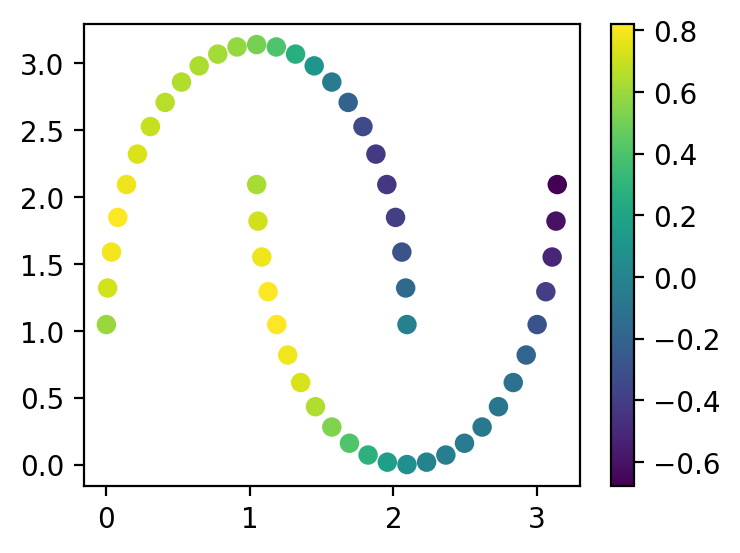

In [7]:
np.random.seed(42)
q = (np.random.uniform(-np.pi, np.pi, size=(4, 2, 3)), 0.0)

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()

Как видно, результат "не очень" и наша цель – попытаться его улучшить.

## Функция потерь

Прежде чем варьировать параметры схемы, нам для начала необходимо понять, а что именно мы хотим оптимизировать. Для этого нам необходимо выбрать функцию потерь.

```{note}
Если у Вас трудности с функциями потерь в таком контексте, то рекомендуем вернуться к вводной лекции про классическое машинное обучение, где эта тема раскрыта достаточно подробно.
```

### Квадратичное отклонение

В качестве функции потерь, которая является дифференцируемой, мы будем использовать наиболее простой вариант -- среднеквадратичное отклонения. Это не самый лучший выбор для задач классификации, но зато самый простой. Простой вариант -- это именно то, что нам нужно в этой лекции:

In [8]:
def cost(q, x, y):
    preds = np.array(apply_node(x, q))
    return np.mean(np.square(preds - y))

### Точность классификации

В качестве метрики качества среднеквадратичное отклонение вообще не подходит -- понять по этой цифре, хорошо или плохо работает модель почти невозможно! Поэтому для оценки модели в целом мы будем использовать точность:

In [9]:
def acc(q, x, y):
    preds = np.sign(apply_node(x, q))
    res = 0
    for p_, y_ in zip(preds, y):
        if np.abs(y_ - p_) <= 1e-2:
            res += 1

    return res / y.shape[0]

## Решение средствами `PennyLane`

Библиотека `PennyLane` может использовать один из нескольких движков для автоматического дифференцирования:

- `NumPy Autograd`
- `PyTorch`
- `Tensorflow`
- `Jax`

По больше части, на наших занятиях мы будем использовать `NumPy` из-за простоты и привычности. Перед тем как разбираться с тем, как же именно происходит дифференцирование квантовой схемы, давайте посмотрим на весь цикл обучения.

```{note}
Внимание, процесс обучения на обычном ноутбуке может занять около минуты! Это связано с трудностью симуляции квантового компьютера на классическом.
```

In [10]:
opt = qml.optimize.GradientDescentOptimizer(stepsize=0.05)
acc_ = []
cost_ = []
ii = []
for i in range(75):
    batch = np.random.randint(0, len(x), (10,))
    x_batch = x[batch, :]
    y_batch = y[batch]
    q = opt.step(lambda q_: cost(q_, x_batch, y_batch), q)

    if i % 5 == 0:
        ii.append(i)
        acc_.append(acc(q, x, y))
        cost_.append(cost(q, x, y))

/usr/share/miniconda/envs/__setup_conda/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


И посмотрим на получившиеся графики точности и функции потерь:

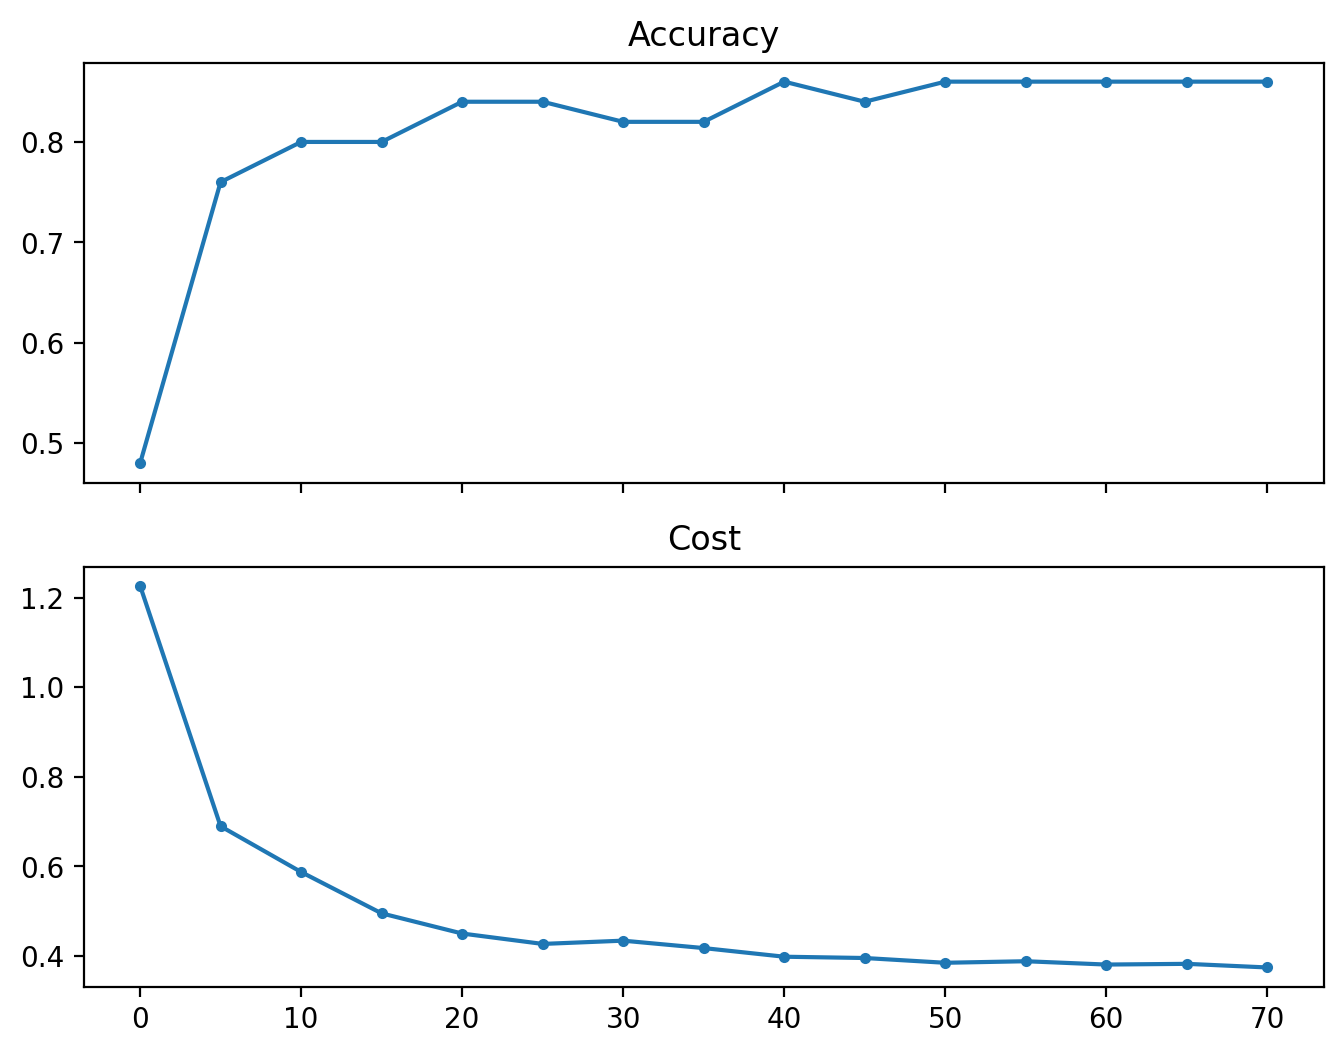

In [11]:
f, ax = plt.subplots(2, figsize=(8, 6), sharex=True)
ax[0].plot(ii, acc_, ".-")
ax[0].set_title("Accuracy")
ax[1].plot(ii, cost_, ".-")
ax[1].set_title("Cost")
plt.show()

А также на результаты классификации:

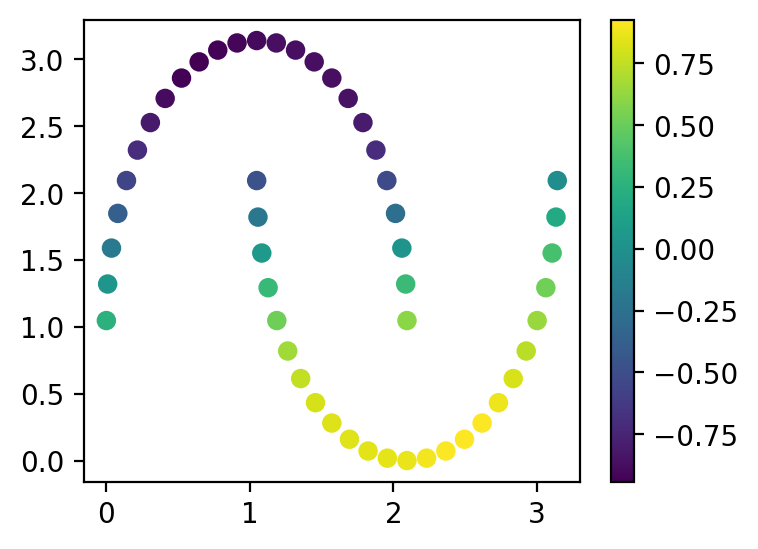

In [12]:
plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()

## А как оно работает?

Теперь, когда мы увидели процесс оптимизации квантовой схемы, давайте попробуем подумать, а как оно на самом деле работает?

### Метод конечных отрезков

Для начала вспомним то, что является геометрическом (или визуальной) интерпретацией градиента функции. Правильно, градиент в каждой точке – это касательная. А приближенное значение угла наклона любой прямой можно найти, взяв конечные отрезки:

$$
\frac{df}{dx} \simeq \frac{\Delta f}{\Delta x} = \frac{f(x + \Delta x) - f(x)}{\Delta x}
$$

Давайте попробуем посчитать градиент нашей квантовой схемы. Для этого инициализируем ее заново случайными параметрами, а потом сравним это с тем значением, которое считает `Autograd`.

In [13]:
np.random.seed(42)
q = (np.random.uniform(0, np.pi, size=(4, 2, 3)), 0.0)


def naive_grad(cost, params, x, y, f0, delta):
    return (cost(params, x, y) - f0) / delta

def grad_i(q, f0, cost, x, y, i):
    new_params = q[0].copy().flatten()
    new_params[i] += 0.05

    return naive_grad(cost, (new_params.reshape(q[0].shape), q[1]), x, y, f0, 0.05)

В качестве эталона возьмем тот градиент, который нам считает `Autograd`:

In [14]:
grad = qml.grad(cost, argnum=0)

Сравним первые пять значений `Autograd` с нашим наивным алгоритмом, взяв $\Delta = 0.05$:

```{note}
Осторожно! Так как мы считаем градиенты очень наивно и на всех точках сразу, то следующий блок кода работает долго!
```

In [15]:
autograd = grad(q, x, y)
f0 = cost(q, x, y)
pretty_print = ""
for i in range(10):
    g_i = grad_i(q, f0, cost, x, y, i)
    pretty_print += f"Naive grad: {g_i:.3f}\tAutograd result: {autograd[0].flatten()[i]:.3f}\n"

print(pretty_print)

Naive grad: -0.028	Autograd result: -0.029
Naive grad: 0.081	Autograd result: 0.081
Naive grad: 0.025	Autograd result: 0.025
Naive grad: 0.013	Autograd result: 0.008
Naive grad: -0.000	Autograd result: -0.011
Naive grad: 0.009	Autograd result: 0.004
Naive grad: 0.025	Autograd result: 0.025
Naive grad: 0.002	Autograd result: -0.003
Naive grad: -0.068	Autograd result: -0.069
Naive grad: 0.009	Autograd result: 0.004



Можно заметить, что даже с таким большим значением $\Delta$ наши оценки получились достаточно близкими к тем, которые получены в `Autograd`. Хотя, конечно, для некоторых значений расхождения заметны и иногда они даже в знаке частной производной.

### Parameter-shift rule

Более точная оценка может быть получена методом, который называется **Parameter-shift**. Он основан на том, что для квантового "черного ящика" $\hat{U}(\theta)$, которым является наша схема, частная производная по параметру $\theta_i$ выражается так:

$$
\nabla_{\theta_i}\langle \hat{U} \rangle (\mathbf{\theta}) = \frac{1}{2}[\langle \hat{U} \rangle (\mathbf{\theta} + \frac{\pi}{2}\mathbf{e_i}) - \langle \hat{U} \rangle (\mathbf{\theta} - \frac{\pi}{2}\mathbf{e_i})]
$$

```{note}
Более строгую формулировку, а также вывод правила parameter-shift можно посмотреть в продвиной лекции этого блока про производные высших порядков.
```

Если по-простому, то оценка частной производной по $i$-му параметру может быть получена вычислением сначала ожидаемого значения схемы с параметром $\theta_i$, смещенным на $\frac{\pi}{2}$ в одну сторону, а потом -- в другую. Давайте запишем это в коде, но перед этим давайте вспомним, как будет выглядеть производная функции потерь (а именно она нам нужна):

$$
\frac{\partial L}{\partial \theta_i} = \frac{\partial (\langle \hat{U} \rangle (\theta) - y)^2}{\partial \theta_i} = 2 (\langle \hat{U} \rangle - y) \frac{\partial \langle \hat{U} \rangle}{\partial \theta_i}
$$

Реализуем явно и наивно эту формулу в коде:

In [16]:
def parameter_shift_i(q, cost, x, y, i, y_hat):
    new_params = q[0].copy().flatten()
    new_params[i] += np.pi / 2

    forward = np.array(apply_node(x, (new_params.reshape(q[0].shape), q[1])))

    new_params = q[0].copy().flatten()
    new_params[i] -= np.pi / 2

    backward = np.array(apply_node(x, (new_params.reshape(q[0].shape), q[1])))

    diff = (y_hat - y)

    return np.mean(2 * diff * (0.5 * (forward - backward)))

И также проверим на первых 10 точках:

In [17]:
y_hat = apply_node(x, q)
pretty_print = ""
for i in range(10):
    g_i = parameter_shift_i(q, cost, x, y, i, y_hat)
    pretty_print += f"Naive grad: {g_i:.3f}\tAutograd result: {autograd[0].flatten()[i]:.3f}\n"

print(pretty_print)

Naive grad: -0.029	Autograd result: -0.029
Naive grad: 0.081	Autograd result: 0.081
Naive grad: 0.025	Autograd result: 0.025
Naive grad: 0.008	Autograd result: 0.008
Naive grad: -0.011	Autograd result: -0.011
Naive grad: 0.004	Autograd result: 0.004
Naive grad: 0.025	Autograd result: 0.025
Naive grad: -0.003	Autograd result: -0.003
Naive grad: -0.069	Autograd result: -0.069
Naive grad: 0.004	Autograd result: 0.004



Как видно, этот результат уже совпадает с тем, что делает "под капотом" `PennyLane` и `Autograd`. На самом деле, правило **parameter-shift** позволяет использовать много интересных хитростей и оптимизаций, но их не получится легко показать без погружения в математические детали метода.

## Что мы узнали?

- Мы попробовали провести полный цикл оптимизации параметров **VQC**
- Научились использовать автоматический расчет градиентов в `PennyLane`
- Познакомились с двумя способами оценки градиента:
  - Метод конечных отрезков
  - Parameter-shift rule